First we will read through all the documents in the data folder and store them in text field in a dataframe along with the right label

In [1]:
import docx2txt
import PyPDF2 
import pptx
from pptx import Presentation
import os
import glob
import pandas as pd
import numpy as np
from xlrd import open_workbook
import re

doc_label=[] 
doc_text=[]
DocPath=[]
DocType=[]
# Other items to be removed - dates, Numbers, Hyperlinks, what about images?, Should we keep headers
Dictionary={"\n":" ","\xa0":" ", "NULL":" ", "NOT NULL": "  ","\u200b" :" "}

os.chdir('C://Users//L833377//Desktop//ClassificationEngineIdeas//data')
rootdir = os.getcwd()

for subdir, dirs, files in os.walk(rootdir):

    for file in files:
        #print(os.path.join(subdir, file))
        filepath = subdir + os.sep + file

        if filepath.endswith(".docx"):
            # read in word file
            #print(filepath)
            result = docx2txt.process(filepath)
            
            for i in Dictionary:
                result=result.replace(i,Dictionary[i])
            doc_text.append(result)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('Word')
            
        # importing required modules 

        elif filepath.endswith(".pdf"):
            # Note that Epic documentation pdf files could not be read. It depends on how the pdf files was generated
            # creating a pdf file object 
            #print(filepath)
            pdfFileObj = open(filepath, 'rb') 
  
            # creating a pdf reader object 
            pdfReader = PyPDF2.PdfFileReader(pdfFileObj,strict=False) 
  
            # printing number of pages in pdf file 
            #print(pdfReader.numPages) 
  
            # creating a page object 
            pageObj = pdfReader.getPage(0) 
  
            # extracting text from page 
            result=pageObj.extractText()
            
        
            #print(result)
            # closing the pdf file object 
            pdfFileObj.close() 
        
            for i in Dictionary:
                result=result.replace(i,Dictionary[i])
                
            doc_text.append(result)
            #Attach the label
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('pdf')
        elif filepath.endswith(".pptx"):        

            # Check the file being processed
            #print(file)
            pptx_txt=str()
            prs = Presentation(filepath)

            for slide in prs.slides:
                for shape in slide.shapes:
                    #print(shape)
                    if hasattr(shape, "text"):
                        pptx_txt += shape.text + " "
                    # For pptx.shapes.graphfrm.GraphicFrame object text could be inside the table object
                    #A graphic frame placeholder can contain a table, a chart, or SmartArt                    
                    elif shape.has_table:
                        table = shape.table
                        for r in table.rows:
                            
                            for c in r.cells:
                                pptx_txt += c.text_frame.text + " "
            for i in Dictionary:
                pptx_txt=pptx_txt.replace(i,Dictionary[i])
            doc_text.append(pptx_txt)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('powerpoint')  
            
        elif filepath.endswith(".xlsx") or filepath.endswith(".xls"):                            
            wb = open_workbook(filepath,"rb")
            xlsx_txt=str()
            for s in wb.sheets():
                #print('Sheet:',s.name)
                
                for row in range(s.nrows):

                    for col in range(s.ncols):
                        value  = (s.cell(row,col).value)
                        try : value = str(int(value))
                        except : pass
                        xlsx_txt+= value + ' '

            for i in Dictionary:
                xlsx_txt=xlsx_txt.replace(i,Dictionary[i])           
            doc_text.append(xlsx_txt)
            #doc_label.append(label[j-1])
            doc_label.append(re.split(r'\\+',filepath)[6])
            DocPath.append(file)
            DocType.append('Excel')           
            
        else:
            pass
                        
df1 = {
    'Label':doc_label,
   'Text':doc_text,
    'DocName':DocPath,
    'DocType':DocType}
 
df1 = pd.DataFrame(df1,columns=['Label','Text','DocName','DocType'])

# overwriting column with replaced value of age  
#df1["Text"]= df1["Text"].str.replace(",", " ", case = False).str.replace("\n", " ", case = False).str.replace("\t"," ",case=False).str.replace(r"\\","",case=False).str.replace("Â","").str.replace("﴿","").str.replace("﴾","").str.lower()

df1.to_csv("KP_Corpus.csv",index=False)
#df1.to_excel("KP_Corpus.xlsx",sheet_name='Extracted_Text')  


In [2]:
df1.head()

,Label,Text,DocName,DocType
0,Claims,Adjudication Match Referrals to Claims Certa...,Adjudication.docx,Word
1,Claims,ALW_CHG_AMT at Claim Line Level =WDA_PRIMARY_A...,APCD Claims Calculation.docx,Word
2,Claims,Region NW Mandated APCD in place? Yes Voluntar...,APCD Questions.pptx,powerpoint
3,Claims,APCD (All Payer Claims Database) Overview Th...,apcd-KPWA.docx,Word
4,Claims,Claims Data Warehouse CDW 101 Module How to Pi...,CDW 101 How to Pick Tables.pptx,powerpoint


Pre-process data

In [3]:
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[\w\.-]+@([\w\.-]+)','',text) # remove email addresses from text
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)
df1['cleanText'] = pd.DataFrame(df1.Text.apply(lambda x: clean_text(x)))
df1['Length']=df1['cleanText'].str.len()

Analysis

Text(0, 0.5, 'Mean document length')

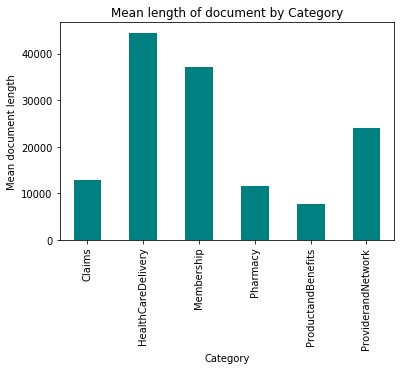

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline
#define a dictionary that maps the Category values to colours, and use the Pandas “replace” function to insert these into the plotting command. 
#colours = {"Claims": "#273c75", "HealthCareDelivery": "#bd32bb","Membership": "#bd5732", "Pharmacy": "#44bd32","ProductandBenefits": "#bd9a32", "ProviderandNetwork": "#bd3250"}
# issue it is only taking the first color in the mapping and aplying to all
colours = {"Claims": "teal", "HealthCareDelivery": "green","Membership": "blue", "Pharmacy": "yellow","ProductandBenefits": "black", "ProviderandNetwork": "red"}
df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=df1['Label'].replace(colours))

#colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','teal']
#df1.groupby("Label")['Length'].mean().plot(kind='bar', title="Mean length of document by Category",color=colors['Label'])

#could also use barh
#plt.xticks(rotation=30, horizontalalignment="left")
#plot.title("Mean length of document by Category")
plt.xlabel("Category")
plt.ylabel("Mean document length")


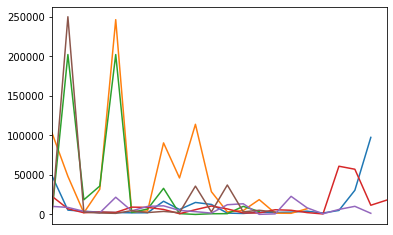

In [5]:
# we can see from the plot below that there are a few outliers on length
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df1.groupby('Label').plot(x='DocName',y='Length', ax=ax, legend=False)
#plt.xticks(rotation=30, horizontalalignment="left")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.show()

Look for documents for which no text was extracted and resolve as needed

In [6]:
df1[df1['Length']<1]

,Label,Text,DocName,DocType,cleanText,Length


In [8]:
df1['category_id']=df1['Label'].factorize()[0]
#use the .sample method of your dataframe to sample all rows without replacement:
# The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).
# to shuffle your dataframe in-place and reset the index, you could do e.g. df = df.sample(frac=1).reset_index(drop=True)
df1['category_id'].sample(frac=1)[0:10]

42    2
28    1
90    4
68    3
71    3
31    1
98    5
96    5
16    0
61    3
Name: category_id, dtype: int64

In [9]:
# Create a new pandas dataframe "category_id_df", which only has unique Labels, also sorting this list in order of category_id values
 
category_id_df = df1[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

In [11]:
df1.head()

,Label,Text,DocName,DocType,cleanText,Length,category_id
0,Claims,Adjudication Match Referrals to Claims Certa...,Adjudication.docx,Word,adjudication match referrals claims certain se...,49095,0
1,Claims,ALW_CHG_AMT at Claim Line Level =WDA_PRIMARY_A...,APCD Claims Calculation.docx,Word,alwchgamt claim line level wdaprimaryallowedam...,5481,0
2,Claims,Region NW Mandated APCD in place? Yes Voluntar...,APCD Questions.pptx,powerpoint,region nw mandated apcd place yes voluntary ap...,4057,0
3,Claims,APCD (All Payer Claims Database) Overview Th...,apcd-KPWA.docx,Word,apcd payer claims database overview washington...,2916,0
4,Claims,Claims Data Warehouse CDW 101 Module How to Pi...,CDW 101 How to Pick Tables.pptx,powerpoint,claims data warehouse cdw module pick views de...,2468,0


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df1.cleanText).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df1.category_id    

In [52]:
import numpy as np

from sklearn.manifold import TSNE

# We will use the entire dataset as it is small 
# Sampling a subset of our dataset because t-SNE is computationally expensive

SAMPLE_SIZE = int(len(features))

np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples

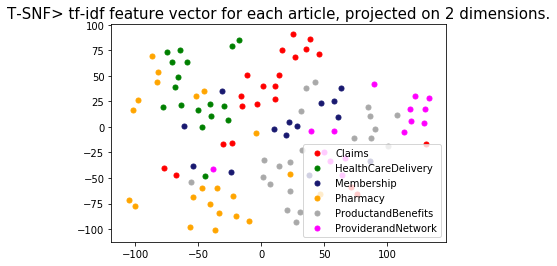

In [53]:

import matplotlib.pyplot as plt

colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','magenta']

# Find points belonging to each category and plot them
# s is the size of each point
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=25, c=colors[category_id], label=category)

plt.title("T-SNF> tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
#plt.figure(figsize=(1,1))

plt.legend(loc='best',edgecolor=None,frameon=None)

#legend(bbox_to_anchor=(1,0), loc="lower right",  bbox_transform=fig.transFigure)

#plt.plot()

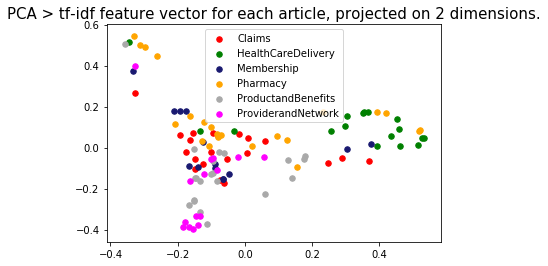

In [54]:
from sklearn.decomposition import PCA

projected_features = PCA(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples
colors = ['red', 'green', 'midnightblue', 'orange', 'darkgrey','magenta']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("PCA > tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [59]:
#export dataset to csv
from pandas import DataFrame
df = DataFrame(df1, columns= ['Label', 'category_id','cleanText','Length','DocName','DocType'])
df.to_csv ('KP_dataset.csv', index = False, header=True)